# imports

In [89]:
# ==========================
# 1. 標準庫
# ==========================
import sys
import os
import io
import json
import glob
import datetime
import random
from pathlib import Path
from typing import Dict, List, Union, Callable, Optional, Tuple
import inspect

# ==========================
# 2. 第三方套件
# ==========================
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import trange
from IPython.display import clear_output, display, HTML
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
from torchsummary import summary

# import cv2  # 如果影片相關再啟用

# ==========================
# 3. 專案設定
# ==========================
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# ==========================
# 4. IPython 魔法指令 (Jupyter 專用)
# ==========================
%reload_ext autoreload
%autoreload 2

# ==========================
# 5. 專案自定義函式庫
# ==========================
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)


# from core_utils.utils_io import (
#     np2pil,      # numpy → PIL Image
#     imwrite,     # 儲存圖像為檔案
#     imencode,    # 編碼圖像為 byte stream
#     im2url,      # 圖像轉 base64 URL（HTML 顯示用）
#     load_emoji,   # 載入 emoji 圖像
#     load_cfd_npy
# )

# from core_utils.utils_image import (
#     imshow,      # 在 notebook 顯示圖像
#     tile2d,      # 多圖拼接
#     zoom         # 放大圖像
# )

# from core_utils.utils_video import (
#     save_video,  # 批次輸出影片
#     VideoWriter  # 逐幀寫入影片（支援 context manager）
# )

# from core_utils.ops_tf_np import (
#     to_rgb,
#     to_rgba,
#     to_alpha,
#     crop_and_resize,
#     get_random_cfd_slices,
#     get_random_cfd_slices_pair
# )


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E4_PI_NCA.utils.helper import (
    to_HWC,
    print_tensor_stats,
    split_cases,
    get_output_path,
    plot_HW3,
    channels_to_rgb
)

clear_output()

# global params

In [90]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
print("output path : ", get_output_path())
CHANNELS_NAMES = ["geo_mask", "topo", "uped", "vped", "Uped", "TKEped", "Tuwped"]
torch.set_default_device(DEVICE)

# dataset params
CASE_DATA = np.load("../dataset/all_cases.npz", allow_pickle=True)
FINAL_EPOCH_SIZE = 512
IMG_SIZE = 64

# model params
CHANNELS = 32

# trainning params
TOTAL_EPOCHS = 5000
TRAIN_BATCH_SIZE = 16
EPOCH_ITEM_REPEAT_NUM = 2
EPOCH_POOL_SIZE = FINAL_EPOCH_SIZE // EPOCH_ITEM_REPEAT_NUM
# final epoch size = EPOCH_POOL_SIZE * EPOCH_ITEM_REPEAT_NUM
REPEAT_NUM_PER_EPOCH = 1
ROLLOUT_MIN = 1
ROLLOUT_MAX = 2

BC_CHANNELS = [0,1]
IC_CHANNELS = [2,3]

EARLYSTOP_PATIENCE = 100
EARLYSTOP_DELTA = 1e-7

Using device: cuda
output path :  ..\outputs\E4-1_urbanDatasetGNCA_20250917-165957


In [91]:
def set_global_seed(seed: int = 42) -> None:
    """
    設定 Python、NumPy、PyTorch 的隨機種子，確保結果可重現。

    Parameters
    ----------
    seed : int, optional
        隨機種子數值, 預設 42
    """
    # Python random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch CUDA (單GPU & 多GPU)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 設定 cudnn 為 deterministic，確保卷積結果可重現
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Global seed set to {seed}")


set_global_seed(1234)

[INFO] Global seed set to 1234


# helper functions

In [92]:
def process_case_data_to_tensor_list(
    case_data: Union[np.ndarray, np.lib.npyio.NpzFile, list] = CASE_DATA,
    channels_n: int = CHANNELS,
) -> List[torch.Tensor]:
    """
    將整個 case_data 轉成 list of 0-1 torch.Tensor，shape = (channels_n, H, W)
    支援輸入 np.ndarray (B,C,H,W), npzfile 或 list of arrays
    """
    case_list = []

    # 將 npzfile 或單一 array 轉成 list of arrays
    if isinstance(case_data, np.lib.npyio.NpzFile):
        keys = list(case_data.files)
        arrays = [case_data[k] for k in keys]
    elif isinstance(case_data, np.ndarray):
        if case_data.ndim == 4:  # B,C,H,W
            arrays = [case_data[i] for i in range(case_data.shape[0])]
        else:  # C,H,W
            arrays = [case_data]
    elif isinstance(case_data, list):
        arrays = case_data
    else:
        raise ValueError(f"Unsupported case_data type: {type(case_data)}")

    for arr in arrays:
        if isinstance(arr, torch.Tensor):
            arr = arr.cpu().numpy()
        else:
            arr = arr.astype(np.float32)

        C, H, W = arr.shape
        # 補零到目標 channels
        if C < channels_n:
            pad = np.zeros((channels_n - C, H, W), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        case_tensor = torch.tensor(arr, dtype=torch.float32, device=DEVICE)
        case_list.append(case_tensor)

    return case_list

In [93]:
all_cases = process_case_data_to_tensor_list()

TRAIN_CASES, EVAL_CASES, TEST_CASES = split_cases(
    all_cases, train_ratio=0.7, eval_ratio=0.2, test_ratio=0.1
)
print(len(TRAIN_CASES), len(EVAL_CASES), len(TEST_CASES))

4 1 1


In [94]:
def create_epoch_pool(
    train_case_list: List[torch.Tensor] = TEST_CASES,
    eval_case_list: Optional[List[torch.Tensor]] = EVAL_CASES,
    test_case_list: Optional[List[torch.Tensor]] = TEST_CASES,
    poolsize: int = EPOCH_POOL_SIZE,
    hw_size: int = IMG_SIZE,
    mode: str = "train",  # 'train', 'eval', 'test'
    eval_full_image_prob: float = 0.5,  # 評估時使用 full image 的機率
) -> torch.Tensor:
    """
    從指定的 case list 隨機生成一個 pool，每個樣本為裁剪的子區域或 full image。

    參數
    ----------
    train_case_list : List[torch.Tensor]
        訓練 case，每個 shape=(channels_n,H,W)
    eval_case_list : Optional[List[torch.Tensor]], default None
        驗證 case，每個 shape=(channels_n,H,W)，mode='eval' 才會使用
    test_case_list : Optional[List[torch.Tensor]], default None
        測試 case，每個 shape=(channels_n,H,W)，mode='test' 才會使用
    poolsize : int, default EPOCH_POOL_SIZE
        pool 中樣本數量
    hw_size : int, default IMG_SIZE
        裁剪區域大小，訓練模式固定使用
    mode : str, default 'train'
        模式：'train', 'eval', 'test'
    eval_full_image_prob : float, default 0.5
        評估模式時使用 full image 的機率

    回傳
    ----------
    torch.Tensor
        shape = (poolsize, channels_n, h_crop, w_crop)
        測試模式直接使用 full image
    """
    # 選擇對應 case list
    if mode == "train":
        case_list = train_case_list
    elif mode == "eval":
        if eval_case_list is None:
            raise ValueError("mode='eval' 需要提供 eval_case_list")
        case_list = eval_case_list
        poolsize = 8
    elif mode == "test":
        if test_case_list is None:
            raise ValueError("mode='test' 需要提供 test_case_list")
        case_list = test_case_list
        poolsize = 1  # 測試模式固定只取 1 個 sample
    else:
        raise ValueError(f"未知 mode='{mode}'，請選擇 'train', 'eval', 'test'")

    B = len(case_list)
    C, H, W = case_list[0].shape
    pool = []
    eval_fullsize_possibilities = np.random.rand()
    eval_size = hw_size if hw_size==H else np.random.randint(hw_size, H)
    # rand = +np.random.randint(-16, 16)
    for _ in range(poolsize):
        # 隨機選一個 case
        b_idx = np.random.randint(0, B)
        arr_tensor = case_list[b_idx]

        # 決定裁剪大小
        if mode == "train":
            hw_crop = hw_size 
        elif mode == "eval":
            # 隨機裁剪或使用 full image
            if eval_fullsize_possibilities < eval_full_image_prob:
                hw_crop = H  # full image
            else:
                hw_crop = eval_size
        else:  # test
            hw_crop = H  # full image
        # hw_crop = hw_size
        # 隨機裁剪起始位置
        h_start = 0 if hw_crop == H else np.random.randint(0, H - hw_crop + 1)
        w_start = 0 if hw_crop == W else np.random.randint(0, W - hw_crop + 1)
        sub = arr_tensor[:, h_start : h_start + hw_crop, w_start : w_start + hw_crop]

        pool.append(sub)

    pool_tensor = torch.stack(
        pool, dim=0
    )  # shape = (poolsize, channels_n, hw_crop, hw_crop)
    return pool_tensor

In [95]:
def init_X(target: torch.Tensor) -> torch.Tensor:
    """
    根據 target 初始化 X，形狀相同 (CHW 或 BCHW)。

    邏輯：
    - channel 0 當作 mask
    - channel 0~6 = mask
    - channel >= 7 = 0

    Parameters
    ----------
    target : torch.Tensor
        shape = (C, H, W) 或 (B, C, H, W)

    Returns
    -------
    torch.Tensor
        與 target 同 shape 的 tensor
    """
    X = torch.zeros_like(target, dtype=torch.float32)

    # BCHW
    mask = (target[:, 0:4, :, :]).float()
    X[:, 0:4, :, :] = mask 

    return X

# viz load data

Y Pool (B,C,H,W) shape = torch.Size([256, 32, 64, 64])
  channel 0: min=0.375000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.500000, max=0.500000
  channel 3: min=0.866025, max=0.866025
  channel 4: min=-1.010551, max=1.295685
  channel 5: min=-1.093766, max=1.405224
  channel 6: min=0.000000, max=1.472492
  channel 7: min=0.000000, max=0.302762
  channel 8: min=-0.063808, max=0.031242
  channel 9: min=0.000000, max=0.000000
  channel 10: min=0.000000, max=0.000000
  channel 11: min=0.000000, max=0.000000
  channel 12: min=0.000000, max=0.000000
  channel 13: min=0.000000, max=0.000000
  channel 14: min=0.000000, max=0.000000
  channel 15: min=0.000000, max=0.000000
  channel 16: min=0.000000, max=0.000000
  channel 17: min=0.000000, max=0.000000
  channel 18: min=0.000000, max=0.000000
  channel 19: min=0.000000, max=0.000000
  channel 20: min=0.000000, max=0.000000
  channel 21: min=0.000000, max=0.000000
  channel 22: min=0.000000, max=0.000000
  channel

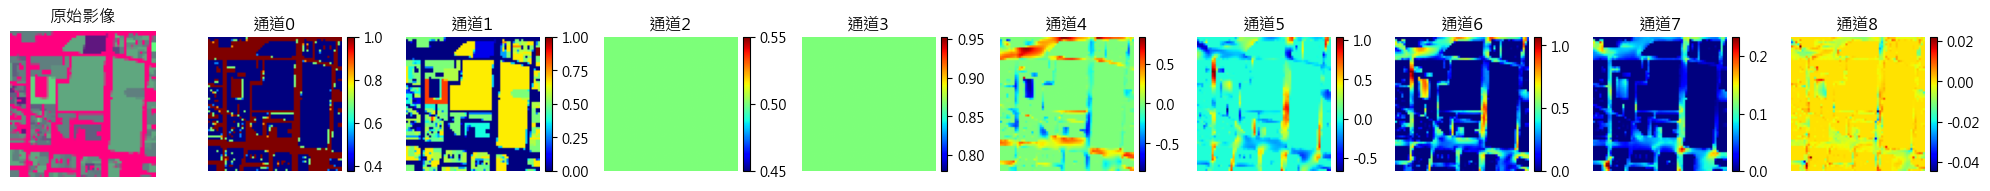

In [96]:
Y_pool = create_epoch_pool()
X_pool = init_X(Y_pool)
# print("Epoch pool shape:", Y_pool.shape)  # (poolsize, hw_size, hw_size, 6)
print_tensor_stats(Y_pool, "Y Pool")
plt_HWC_split_channels(to_HWC(Y_pool[0,:9,:,:]))


# define Neural Net

## model

In [97]:
def set_kernels(angle: float = 0.0, device: str = "cpu") -> torch.Tensor:
    """
    建立 NCA 用的基本卷積核，包含 identity, dx, dy (旋轉後)

    Parameters
    ----------
    angle : float, optional
        kernel 旋轉角度, 預設 0
    device : str, optional
        放置張量的裝置, 預設 "cpu"

    Returns
    -------
    torch.Tensor
        shape = (3, 3, 3)，三個 kernel
    """
    ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
    sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
    
    kernel = torch.stack([ident, sobel_x, sobel_x.T, lap])

    return kernel

In [98]:
# ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
# sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
# lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# def perchannel_conv(x, filters):
#   '''filters: [filter_n, h, w]'''
#   b, ch, h, w = x.shape
#   y = x.reshape(b*ch, 1, h, w)
#   y = F.pad(y, [1, 1, 1, 1], 'replicate')
#   y = F.conv2d(y, filters[:,None])
#   return y.reshape(b, -1, h, w)

# def perception(x):
#   filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
#   return perchannel_conv(x, filters)

class CAModel(nn.Module):
    def __init__(self, channel_n: int = CHANNELS, kernel_count: int = 4):
        """
        Neural Cellular Automata 模型

        Parameters
        ----------
        channel_n : int
            channel 數量
        kernel_count : int
            kernel 個數 (通常為 3: identity, dx, dy)
        """
        super().__init__()
        self.channel_n = channel_n
        self.kernel_count = kernel_count

        # ===== rule block =====
        # 直接寫在 CAModel 裡，包含 residual 與多層卷積
        hidden_dim = 128
        self.rule_block = nn.Sequential(
            nn.Conv2d(channel_n * kernel_count, hidden_dim, kernel_size=1),
            nn.Tanh(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1),
            nn.Tanh(),
            nn.Conv2d(hidden_dim, channel_n, kernel_size=1, bias=False),
        )

    def perceive_block(self, x: torch.Tensor, angle: float = 0.0) -> torch.Tensor:
        """
        感知 (perceive) block: 對每個 channel 套用多個卷積核

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        angle : float, optional
            kernel 旋轉角度, 預設 0

        Returns
        -------
        torch.Tensor
            shape = (B, C * kernel_count, H, W)
        """
        b, c, h, w = x.shape
        device = x.device

        base_kernel = set_kernels(angle=angle, device=device)  # (3, 3, 3)
        kernel = base_kernel.unsqueeze(1).repeat(c, 1, 1, 1)  # (3*C, 1, 3, 3)

        # depthwise conv (groups = c)
        y = F.conv2d(x, kernel, padding=1, groups=c)  # (B, C*3, H, W)
        return y

    def forward_pass(self, x: torch.Tensor, angle: float = 0.0) -> torch.Tensor:
        """
        單步更新

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        angle : float, optional
            kernel 旋轉角度

        Returns
        -------
        torch.Tensor
            更新後的張量, shape = (B, C, H, W)
        """
        # print("Input shape:", x.shape)
        y = self.perceive_block(x, angle)
        # print("Perceived shape:", y.shape)
        # y = perception(x)
        # print("Perceived shape:", y.shape)
        dx = self.rule_block(y)
        # print("Delta shape:", dx.shape)
        b, c, h, w = y.shape
        # 只在 mask 為 1 的位置更新
        mask = x[:, :4, :, :]  # 前2通道 不改變 wall mask, topo
        updated = x + dx 
        return torch.cat([mask, updated[:, 4:, :, :]], dim=1)

    def forward(self, x: torch.Tensor, n_times: int = 1) -> torch.Tensor:
        """
        多步迭代

        Parameters
        ----------
        x : torch.Tensor
            shape = (B, C, H, W)
        n_times : int
            更新次數

        Returns
        -------
        torch.Tensor
            shape = (B, C, H, W)
        """
        for _ in range(n_times):
            x = self.forward_pass(x)
        return x


model = CAModel(channel_n=CHANNELS).to(DEVICE)
summary(model, (CHANNELS, IMG_SIZE, IMG_SIZE), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]          16,512
              Tanh-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 128, 64, 64]          16,512
              Tanh-4          [-1, 128, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,096
Total params: 37,120
Trainable params: 37,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 17.00
Params size (MB): 0.14
Estimated Total Size (MB): 17.64
----------------------------------------------------------------


In [99]:
# class CAModel(nn.Module):
#     def __init__(self, in_channels=16, out_channels=16,
#                  channel_n=16, kernel_count=4,
#                  kernel_size=3, depth=3):
#         super().__init__()
#         self.channel_n = channel_n
#         self.kernel_count = kernel_count
#         self.depth = depth

#         self.kernels = nn.ParameterList([
#             nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
#             for _ in range(depth)
#         ])
#     def perceive_block(self, x: torch.Tensor, angle: float = 0.0) -> torch.Tensor:
#         """
#         感知 (perceive) block: 對每個 channel 套用多個卷積核

#         Parameters
#         ----------
#         x : torch.Tensor
#             shape = (B, C, H, W)
#         angle : float, optional
#             kernel 旋轉角度, 預設 0

#         Returns
#         -------
#         torch.Tensor
#             shape = (B, C * kernel_count, H, W)
#         """
#         b, c, h, w = x.shape
#         device = x.device

#         base_kernel = set_kernels(angle=angle, device=device)  # (3, 3, 3)
#         kernel = base_kernel.unsqueeze(1).repeat(c, 1, 1, 1)  # (3*C, 1, 3, 3)

#         # depthwise conv (groups = c)
#         y = F.conv2d(x, kernel, padding=1, groups=c)  # (B, C*3, H, W)
#         return y
    
#     def forward_pass(self, x):
#         # y = self.perceive_block(x)
#         print(x.shape)

#         B, C, H, W = x.shape
#         dx_fft = torch.fft.fft2(x)
#         dx = dx_fft.real

#         for k in self.kernels:
#             F_fft = torch.fft.fft2(k, s=(H, W))
#             F = F_fft.real
#             dx_fft = torch.einsum("bchw,oihw->bohw", dx_fft, F)

#         dx = torch.fft.ifft2(dx_fft).real
#         updated = x + dx
#         return updated

#     def forward(self, x, n_times=1):
#         for _ in range(n_times):
#             x = self.forward_pass(x)
#         return x
    
# model = CAModel(in_channels=CHANNELS, out_channels=CHANNELS).to(DEVICE)
# summary(model, input_size=(CHANNELS, IMG_SIZE, IMG_SIZE), batch_size=1, device=DEVICE)


cases : cfd les sim but time average 
epoch_pool : sample from cases and get (batch,channel, h, w) 
item_pool : repeat epoch_pool n times to get (batch*n ,channel, h, w) and store temp data while training
train_batch : actual train batch to run in model (8,c,h,w)
iter_count : how many times to iter all batch once in item_pool (batch*n)/train_batch_size 
repeat_times: default 1


training strategies :

for epoch in epoch_count:
    create new epoch_pool
    for i in iter_count*repeat_times
        train_batch = item_pool[i*train_batch_size: i*train_batch_size+i*train_batch_size, :,:,:]
        pass train_batch forward model random (0,32) times then bptt


## EarlyStop

In [100]:
class EarlyStopper:
    """
    Early stopping helper
    """
    def __init__(self, patience=EARLYSTOP_PATIENCE, min_delta=EARLYSTOP_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def step(self, loss):
        if loss + self.min_delta < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


## epoch step

### train step

In [101]:
# ====== 訓練函式 ======
def train_one_epoch(
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    train_batch_size: int = TRAIN_BATCH_SIZE,
    item_pool_repeats: int = EPOCH_ITEM_REPEAT_NUM,
    repeats_per_epoch: int = REPEAT_NUM_PER_EPOCH,
    rollout_min: int = ROLLOUT_MIN,
    rollout_max: int = ROLLOUT_MAX,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    執行一個 epoch 的訓練迴圈，回傳最後一個 batch 的 loss 與對應資料。

    參數:
        model: nn.Module, 神經網路模型
        optimizer: PyTorch Optimizer
        loss_fn: nn.Module, 損失函數
        train_batch_size: int, 單次訓練的 batch 大小
        item_pool_repeats: int, 將 epoch pool 複製的次數
        repeats_per_epoch: int, 每個 epoch 重複迭代的次數
        rollout_min: int, 最小演化步數
        rollout_max: int, 最大演化步數

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """
    model.train()

    # 建立 epoch 的子區域池
    epoch_pool = create_epoch_pool(mode="train").to(DEVICE)

    # 複製 item pool
    epoch_pool_extended = epoch_pool.repeat((item_pool_repeats, 1, 1, 1))
    pool_size = len(epoch_pool_extended)
    pool_iterations = pool_size // train_batch_size
    print(
        "Epoch pool shape:", epoch_pool_extended.shape
    )  # (poolsize, channels_n, hw_size, hw_size)

    # 內層 batch 迴圈進度條
    for _ in range(repeats_per_epoch):
        for i in trange(pool_iterations, desc="train epoch", unit="batch"):
            # 抽取一個訓練批次
            Y_batch = epoch_pool_extended[
                i * train_batch_size : (i + 1) * train_batch_size
            ].to(DEVICE)

            # 隨機決定演化步數
            rollout_steps = random.randint(rollout_min, rollout_max)

            # 前向傳播
            X_batch = init_X(Y_batch)
            X_pred = model(X_batch, n_times=rollout_steps)

            # 計算 loss 並反向傳播
            loss_dict = loss_fn(X_pred, Y_batch)
            total_loss = sum(loss_dict.values())

            optimizer.zero_grad()
            total_loss.backward()
            for p in model.parameters():
                p.grad /= (p.grad.norm()+1e-8) # normalize gradients
            optimizer.step()
            


        batch_dict = {
            "Y": Y_batch,
            "X0": X_batch,
            "X1": X_pred,
            "diff": Y_batch - X_pred,
        }

    return loss_dict, batch_dict

### eval step

In [102]:
# ====== 測試函式 ======
def evaluate_one_epoch(
    model: torch.nn.Module, loss_fn: torch.nn.Module, rollout_steps: int = ROLLOUT_MAX
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    在測試集上做評估，計算平均 loss。

    Parameters
    ----------
    model : torch.nn.Module
        訓練好的模型
    loss_fn : torch.nn.Module
        損失函式
    rollout_steps : int, optional
        每個測試樣本 rollout 步數 (default=10)

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """
    model.eval()

    with torch.no_grad():
        # 建立 epoch 的子區域池
        Y_batch = create_epoch_pool(mode="eval").to(DEVICE)
        X_batch = init_X(Y_batch)
        X_pred = model(X_batch, n_times=rollout_steps)
        loss_dict = loss_fn(X_pred, Y_batch)
        batch_dict = {
            "Y": Y_batch,
            "X0": X_batch,
            "X1": X_pred,
            "diff": Y_batch - X_pred,
        }

    return loss_dict, batch_dict

## training loop

In [103]:
def viz_epochs(batch_dict, max_channels=9):
    max_batch = next(iter(batch_dict.values())).shape[0]
    random_idx = np.random.randint(0, max_batch)
    out = []

    for batch_tensor in batch_dict.values():

        hwc = to_HWC(batch_tensor[random_idx])[..., :max_channels]  # 只看前7個channel

        chw3 = channels_to_rgb(hwc)
        chw3 = torch.from_numpy(chw3)

        # F.pad 的 pad 格式是 維度由後往前
        chw3 = F.pad(chw3, (0, 0, 5, 0, 5, 0), value=1.0)
        chw3 = [chw3[i] for i in range(max_channels)]

        out.append(torch.hstack(chw3))
    out.reverse()
    out = torch.vstack(out)
    plot_HW3(out)

In [104]:
from torch.optim.lr_scheduler import _LRScheduler
# ====== 主訓練流程 ======
def run_training(
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    total_epochs: int = TOTAL_EPOCHS,
    lr_sched: Optional[_LRScheduler] = None
) -> None:
    """
    執行完整訓練流程

    Parameters
    ----------
    model : torch.nn.Module
        要訓練的模型
    optimizer : torch.optim.Optimizer
        模型優化器
    loss_fn : torch.nn.Module
        損失函式
    total_epochs : int, optional
        訓練總迴圈數, default=100

    Returns
    -------
    None
        訓練過程中直接更新 model 參數
    """

    train_loss_log: list[float] = []
    eval_loss_log: list[float] = []
    OutPath = get_output_path(Suffix="loss")

    # Early stopper
    early_stopper = EarlyStopper()
    
    for epoch in range(total_epochs):
        # train step
        train_loss_dict, train_batch_dict = train_one_epoch(model, optimizer, loss_fn)
        train_loss = sum(train_loss_dict.values())
        train_loss_log.append(train_loss.item())
        lr_sched.step()

        # eval step
        eval_loss_dict, eval_batch_dict = evaluate_one_epoch(model, loss_fn)
        eval_loss = sum(eval_loss_dict.values())
        eval_loss_log.append(eval_loss.item())

        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            viz_loss(train_loss_log, eval_loss_log, log_scale=True, window=200)
            print("train")
            viz_epochs(train_batch_dict)
            print("eval")
            viz_epochs(eval_batch_dict)
            # print("viz pool")
            # viz_pool(to_HWC(epoch_pool[:,2:5,:,:]), epoch, output_path=get_output_path(Suffix="pool"))

        
        # Early stopping
        val_loss_avg = eval_loss.item()  # 取最後一個 batch 的 loss 或做平均
        if early_stopper.step(val_loss_avg):
            print(f"Early stopping at epoch {epoch}")
            break

## loss function

In [105]:
def divergence_loss(u, v):
    # u, v shape: [B, 1, H, W]  (速度分量)
    du_dx = torch.gradient(u, dim=-1)[0]  # ∂u/∂x
    dv_dy = torch.gradient(v, dim=-2)[0]  # ∂v/∂y
    div = du_dx + dv_dy
    return torch.mean(div**2)  # L2 loss on divergence


def data_overflow_loss(x: torch.Tensor) -> torch.Tensor:
    """
    對溢出 [-1, 1] 的值加入懲罰
    """
    overflow_loss = (x - x.clamp(-1.0, 1.0)).abs().sum() / x.numel()  # normalize
    return overflow_loss


def data_mse_loss(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    計算 x 與 y 之間的 MSE loss
    """
    mse = nn.MSELoss()
    x = x[:, 4:9, :, :]  # 只取前 7 個 channel
    y = y[:, 4:9, :, :]
    loss = mse(x, y)

    return loss


def obstacle_loss(x: torch.Tensor) -> torch.Tensor:
    """
    檢查 obstacle cell (mask=0) 內，其他 channel 的值應該趨近於 0

    Args:
        x: Tensor [B, C, H, W], channel 0 = geo_mask (1=air, 0=object)

    Returns:
        torch.Tensor: scalar loss
    """
    mask = x[:, 0:1, ...]  # [B, 1, H, W]
    phys = x[:, 4:7, ...]  # [B, 7, H, W] 取前 7 個物理量通道

    obj_mask = 1.0 - mask  # object cell = 1, air = 0
    masked_phys = phys * obj_mask  # 只保留物體內的值
    loss = torch.mean(masked_phys**2)
    return loss

def fft_loss(x: torch.Tensor, y: torch.Tensor, norm: str = 'L2') -> torch.Tensor:
    """
    Compute per-channel FFT loss between x and y.

    Parameters
    ----------
    x, y : torch.Tensor
        Input and target tensors, shape = (B, C, H, W)
    norm : str
        'L1' or 'L2' for difference metric

    Returns
    -------
    torch.Tensor
        Scalar loss
    """
    # FFT: compute 2D FFT per channel
    X_fft = torch.fft.fft2(x[:, 4:7, ...], norm='ortho')   # (B, C, H, W), complex
    Y_fft = torch.fft.fft2(y[:, 4:7, ...], norm='ortho')

    # Compute magnitude difference
    diff = torch.abs(X_fft - Y_fft)  # magnitude difference

    if norm.upper() == 'L1':
        loss = diff.mean()
    elif norm.upper() == 'L2':
        loss = (diff ** 2).mean()
    else:
        raise ValueError("norm should be 'L1' or 'L2'")

    return loss

def custom_loss(x: torch.Tensor, y: torch.Tensor) -> dict:

    return {
        "mse_loss": data_mse_loss(x, y),
        "obstacle_loss": obstacle_loss(x),
        "overflow_loss": data_overflow_loss(x),
        "fft_loss": fft_loss(x, y, norm='L2')
        # "divergence_loss": divergence_loss(x[:,2:3,...], x[:,3:4,...])
    }

# main process

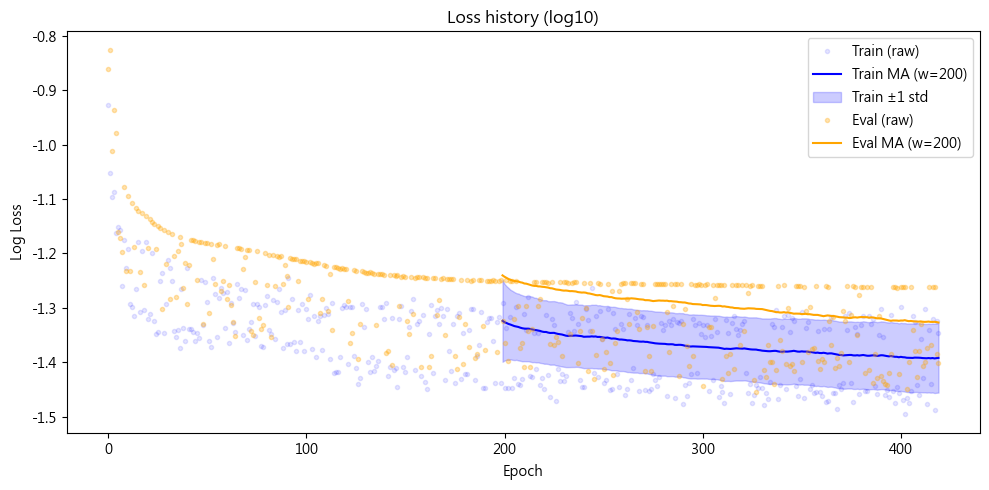

train


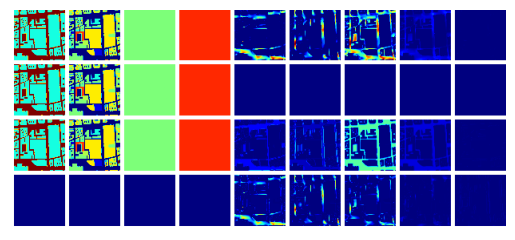

eval


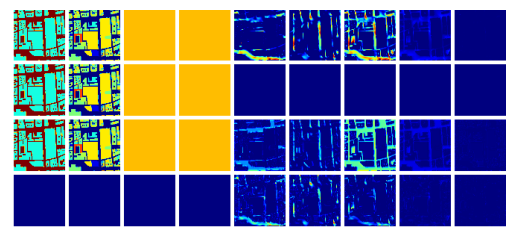

Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 112.34batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 117.87batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 123.48batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 132.86batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 116.90batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 125.37batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 113.05batch/s]


Epoch pool shape: torch.Size([512, 32, 64, 64])


train epoch: 100%|██████████| 32/32 [00:00<00:00, 138.49batch/s]

Early stopping at epoch 427


In [106]:
model = CAModel(channel_n=CHANNELS).to(DEVICE)
optimizer = Optimizer.Adam(model.parameters(), lr=1e-5)
# lr_sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [300, 600], 0.3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)


run_training(model, optimizer, loss_fn=custom_loss, lr_sched=lr_sched)

## viz perception kernel

In [107]:
def perception_viz(x):
    filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
    y = perchannel_conv(x, filters)  # [B, C*kernel_count, H, W]
    B, CK, H, W = y.shape
    C = x.shape[1]
    kernel_count = CK // C
    # reshape成 [B, C, kernel_count, H, W]
    y = y.view(B, C, kernel_count, H, W)
    return y



def viz_perception_grid(x, perception_fn, cmap='jet'):
    """
    可視化每個 channel 經過每個 kernel 的 response

    Parameters
    ----------
    x : torch.Tensor
        shape = [B, C, H, W]，取 batch 0
    perception_fn : function
        輸入 x，輸出 shape = [B, C, kernel_count, H, W]
    cmap : str
        colormap
    """
    y_viz = perception_fn(x[0:1])  # 取 batch 0
    _, C, K, H, W = y_viz.shape

    fig, axes = plt.subplots(C, K, figsize=(2*K, 2*C))
    
    for c in range(C):
        for k in range(K):
            ax = axes[c, k] if C > 1 else axes[k]
            im = ax.imshow(y_viz[0, c, k].detach().cpu(), cmap=cmap)
            ax.axis('off')
            if c == 0:
                ax.set_title(f"kernel{k}")
            # 每個 subplot 加 colorbar
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


epoch_pool = create_epoch_pool(mode="test").to(DEVICE)[:,:7,:,:]
print(epoch_pool.shape)
viz_perception_grid(epoch_pool, perception_viz)



torch.Size([1, 7, 96, 96])


NameError: name 'ident' is not defined